In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

- [x] Предобработка данных
- [ ] Анализ данных о регистрациях и займах. Динамика по времени, конверсия + графики + выводы

## Чтение данных и объединение таблиц с данными о регистрациях

In [2]:
# читаем данные
regs1 = pd.read_excel('regs1.xlsx')
regs2 = pd.read_excel('regs2.xlsx')
loans = pd.read_excel('loans.xlsx')

In [3]:
# т.к данные с регистрациями предоставлены в 2ух файлах нам необходимо объеденить их в 1
regs = regs1.append(regs2, ignore_index=True)

## Предобработка данных

### Регистрации

In [4]:
# посмотрим на общую информацию
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481285 entries, 0 to 1481284
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   cid              1481285 non-null  int64         
 1   uid              1481285 non-null  object        
 2   ts               1481285 non-null  datetime64[ns]
 3   is_reg_complete  1481285 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 45.2+ MB


In [5]:
# изучим срез данных
regs.sample(5)

,cid,uid,ts,is_reg_complete
678070,3880586,0F19018F-C6D8-4244-BD3F-DBB3A419732C,2019-08-31 10:25:36.331,0
983389,2984894,6ACC1316-1722-47FA-87BB-AC01689B03C7,2019-01-31 20:03:21.969,0
632710,3828900,1D063F4A-017A-4FB3-A0A0-3213F5C0D0FE,2019-08-14 00:24:41.636,1
890296,3073214,61727C97-A99E-4BD9-82B0-E8727BED8BA6,2019-02-20 05:53:27.097,0
662557,3775811,A4013ED4-73C7-4E18-A7A8-A46D8B3FDBB3,2019-08-01 11:58:36.108,1


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>ts</b> - время начала регистрации<br>
<b>is_reg_complete</b> - отметка о завершени регистрации<br>

In [6]:
# проверим таблицу на наличие пропусков и дубликатов
display(regs.isna().sum())
display(regs.duplicated().sum())

cid                0
uid                0
ts                 0
is_reg_complete    0
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> все ок, двигаемся дальше
</div>

### Займы

In [7]:
# посмотрим на общую информацию
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397272 entries, 0 to 397271
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   cid       397272 non-null  int64         
 1   uid       397272 non-null  object        
 2   start_ts  381801 non-null  datetime64[ns]
 3   value     397272 non-null  float64       
 4   term      397272 non-null  int64         
 5   status    397272 non-null  object        
 6   end_ts    277092 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 21.2+ MB


In [8]:
# изучим срез данных
loans.sample(5)

,cid,uid,start_ts,value,term,status,end_ts
281352,2937718,F423DAE6-9A0B-4543-8309-5716B42EE187,2020-05-02,20000.0,30,Погашен,2020-06-19 23:59:59.999
1863,2859369,8861CDB5-C28B-4AD6-8BF5-5A8AA622E42C,2019-01-09,2800.0,14,Погашен,2019-01-17 23:59:59.999
101557,3563695,A4294DE6-174E-4B9F-8805-48928871314D,2019-07-03,6741.0,30,Погашен,2019-07-03 23:59:59.999
256776,4292241,A8DF8FFB-298B-44DB-B085-8A3DB484F71B,2020-03-16,4000.0,30,Погашен,2020-04-25 23:59:59.999
337051,4250758,0047FF53-8730-44B0-A65E-130B4954BFD0,2020-08-04,23000.0,42,На реструктуризации,NaT


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>start_ts</b> - время получения займа<br>
<b>value</b> - сумма<br>
<b>term</b> - срок<br>
<b>status</b> - статус на текущий момент<br>
<b>end_ts</b> - время веозврата займа

In [9]:
# проверим таблицу на наличие пропусков и дубликатов
display(loans.isna().sum())
display(loans.duplicated().sum())

cid              0
uid              0
start_ts     15471
value            0
term             0
status           0
end_ts      120180
dtype: int64

1743

<div class="alert alert-block alert-success">
<b>Вывод:</b> есть пропуски и дубликаты, обработаем их
</div>

In [10]:
# посмотим на стутусы
loans[loans['start_ts'].isna()]['status'].value_counts()

Отменён           15447
Не подтверждён       24
Name: status, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b> фактически эти статусы говорят о том, что клиент не получил деньги
</div>

In [11]:
# Удалим эти строки
loans.dropna(subset=['start_ts'], inplace=True)

In [12]:
loans.isna().sum()

cid              0
uid              0
start_ts         0
value            0
term             0
status           0
end_ts      104709
dtype: int64

In [13]:
# Посмотрим статусы займов, у которых отсутствуетм время погашения
loans[loans['end_ts'].isna()]['status'].value_counts()

Просрочен              41423
На цессии              39043
Активен                14337
На реструктуризации     8616
Отменён                 1025
Списан                   265
Name: status, dtype: int64

In [14]:
# посмотрим, остались ли дубликаты
loans.duplicated().sum()

0

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>дубли теперь отсутствуют
        <li>пропуски в end_ts фактически указывают на то, что заем не был закрыт на момент анализа данных
    </ul>
</div>
Теперь переходоим к анализу данных

## Аналитика данных

### 1. Анализ данных о реистрациях и займах. Динамика по времени, конверсия + графики + выводы

Нам нужна таблица, в которой будут данные в динамике по месяцам:
- Общее кол-во регистраций
- Кол-во успешных (завершенных) регистраций
- Общее кол-во займов
- Кол-во новых займов
- Кол-во повторных займов

#### 1.1 Групиировка данных о регистарциях

In [15]:
# добавим в таблицу regs столбцы: date, week, month - день, неделя и месяц регистрации
regs['date'] = regs['ts'].dt.date
regs['week'] = regs['ts'].dt.to_period('W').apply(lambda r: r.start_time)
regs['month'] = regs['ts'].astype('datetime64[M]')

# проверяем
regs.head()

,cid,uid,ts,is_reg_complete,date,week,month
0,3137743,CFE02F00-0000-0000-0000-000000000000,2019-03-07 08:11:52.717,1,2019-03-07,2019-03-04,2019-03-01
1,3137786,FAE02F00-0000-0000-0000-000000000000,2019-03-07 08:11:52.717,1,2019-03-07,2019-03-04,2019-03-01
2,3138236,BCE22F00-0000-0000-0000-000000000000,2019-03-07 08:11:52.717,1,2019-03-07,2019-03-04,2019-03-01
3,3137950,9EE12F00-0000-0000-0000-000000000000,2019-03-07 08:11:52.717,1,2019-03-07,2019-03-04,2019-03-01
4,3138043,FBE12F00-0000-0000-0000-000000000000,2019-03-07 08:11:52.717,1,2019-03-07,2019-03-04,2019-03-01


In [16]:
# сгруппируем данные по месяцам, посчитаем общее кол-во регистраци и кол-во успешных регистраций
regs_by_month = regs.groupby(by='month').agg({'cid': 'nunique', 'is_reg_complete': 'sum'})
regs_by_month.columns = ['total_regs', 'success_regs']

# смотрим
regs_by_month

,total_regs,success_regs
month,,
2019-01-01,129245,83496
2019-02-01,109871,67622
2019-03-01,141537,86071
2019-04-01,158074,95000
2019-05-01,73849,48334
2019-06-01,57813,38789
2019-07-01,95982,61914
2019-08-01,85034,53188
2019-09-01,18303,12616


#### 1.2 Групиировка данных о займах

In [17]:
# у нас уже есть сгруппированные по месяцам данные о регистрациях, теперь тоже самое нужно сделать с займами
# но для начала - добавить в таблицу loans столбцы: date, week, month - день, неделя и месяц регистрации

loans['date'] = loans['start_ts'].dt.date
loans['week'] = loans['start_ts'].dt.to_period('W').apply(lambda r: r.start_time)
loans['month'] = loans['start_ts'].astype('datetime64[M]')

# проверяем
loans.head()

,cid,uid,start_ts,value,term,status,end_ts,date,week,month
0,2825209,A931081F-8EAD-4802-8142-D65F59D6ADFA,2019-01-01,9900.0,30,Погашен,2019-01-10 23:59:59.999,2019-01-01,2018-12-31,2019-01-01
1,2825218,1CA2E2D5-7D4C-4925-AB53-0D501BC5ED4F,2019-01-01,17000.0,28,Погашен,2019-01-10 23:59:59.999,2019-01-01,2018-12-31,2019-01-01
7,2825331,7F72F995-8461-4EE0-B85F-15C1D9E5E1DC,2019-01-01,9800.0,19,На цессии,NaT,2019-01-01,2018-12-31,2019-01-01
8,2825254,778C25D8-878A-4992-804B-4E5EF8CC08C7,2019-01-01,5000.0,20,На цессии,NaT,2019-01-01,2018-12-31,2019-01-01
9,2825359,58BCB5F4-9954-4ADA-A533-24405DD9C00D,2019-01-01,7000.0,30,Погашен,2019-03-02 23:59:59.999,2019-01-01,2018-12-31,2019-01-01


In [18]:
# для начала для каждого юзера найдем месяц первого займа
new_loans_by_month = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'month': 'first'}).reset_index()

# теперь сгруппируем данные по месяцам и подсчитаем кол-во уникальны займов
new_loans_by_month = new_loans_by_month.groupby(by='month').agg({'cid': 'count'})
new_loans_by_month.columns = ['new_loans']

# проверяем
new_loans_by_month

,new_loans
month,
2019-01-01,7874
2019-02-01,8775
2019-03-01,12097
2019-04-01,13205
2019-05-01,7160
2019-06-01,4920
2019-07-01,9910
2019-08-01,8474
2019-09-01,4067


In [19]:
# теперь посчитаем общее кол-во займов по месяцам
total_loans_by_month = loans.groupby(by='month').agg({'cid': 'count'})
total_loans_by_month.columns = ['total_loans']

# проверяем
total_loans_by_month

,total_loans
month,
2019-01-01,9051
2019-02-01,13253
2019-03-01,20531
2019-04-01,23563
2019-05-01,16104
2019-06-01,12850
2019-07-01,18986
2019-08-01,19323
2019-09-01,12914


In [20]:
# объеденим таблицы total_loans_by_month и new_loans_by_month
loans_by_month = pd.merge(total_loans_by_month, new_loans_by_month, on='month')

# рассчитаем кол-во повторных займов
loans_by_month['repeated_loans'] = loans_by_month['total_loans'] - loans_by_month['new_loans']

# проверяем
loans_by_month

,total_loans,new_loans,repeated_loans
month,,,
2019-01-01,9051,7874,1177
2019-02-01,13253,8775,4478
2019-03-01,20531,12097,8434
2019-04-01,23563,13205,10358
2019-05-01,16104,7160,8944
2019-06-01,12850,4920,7930
2019-07-01,18986,9910,9076
2019-08-01,19323,8474,10849
2019-09-01,12914,4067,8847


#### 1.3 Объеденение данных в обну таблицу

In [21]:
total_grouped_data = pd.merge(regs_by_month, loans_by_month, on='month')

total_grouped_data

,total_regs,success_regs,total_loans,new_loans,repeated_loans
month,,,,,
2019-01-01,129245,83496,9051,7874,1177
2019-02-01,109871,67622,13253,8775,4478
2019-03-01,141537,86071,20531,12097,8434
2019-04-01,158074,95000,23563,13205,10358
2019-05-01,73849,48334,16104,7160,8944
2019-06-01,57813,38789,12850,4920,7930
2019-07-01,95982,61914,18986,9910,9076
2019-08-01,85034,53188,19323,8474,10849
2019-09-01,18303,12616,12914,4067,8847


#### 1.4 Графики

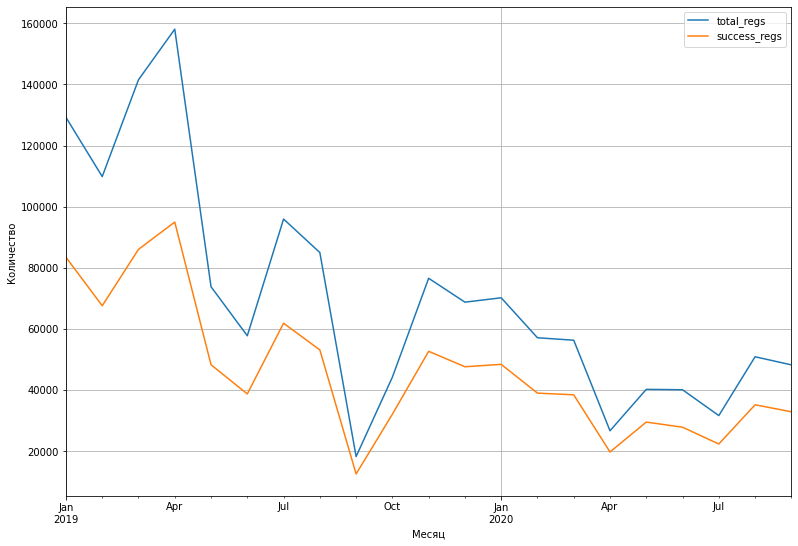

In [22]:
# построим график динамики регистраций по месяцам
total_grouped_data[['total_regs', 'success_regs']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

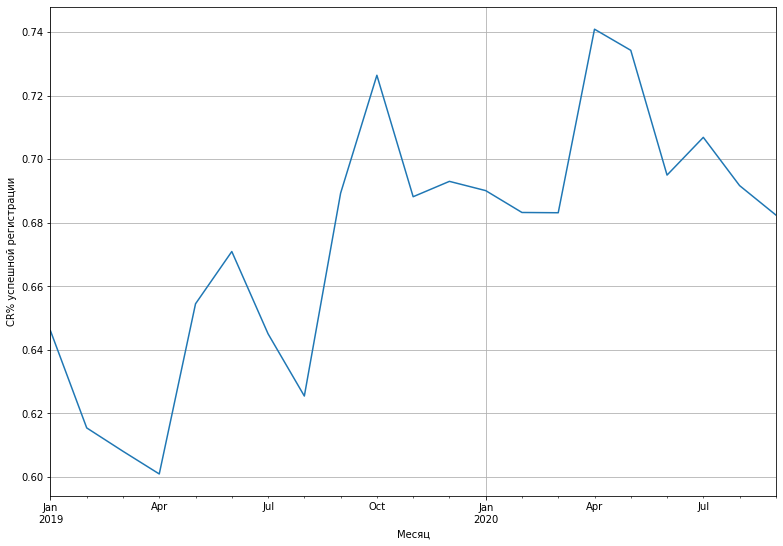

In [23]:
# а также ихучим конверсию из всех регистраций в успешную
(total_grouped_data['success_regs'] / total_grouped_data['total_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>количетсво регистраций (всех/успешных) стабильно сокращалось с апрелья 2019 года
        <li>при этом конверсия в успешную регистрацию за этот же период выросла с 0.6-0.62 до 0.7
    </ul>
</div>

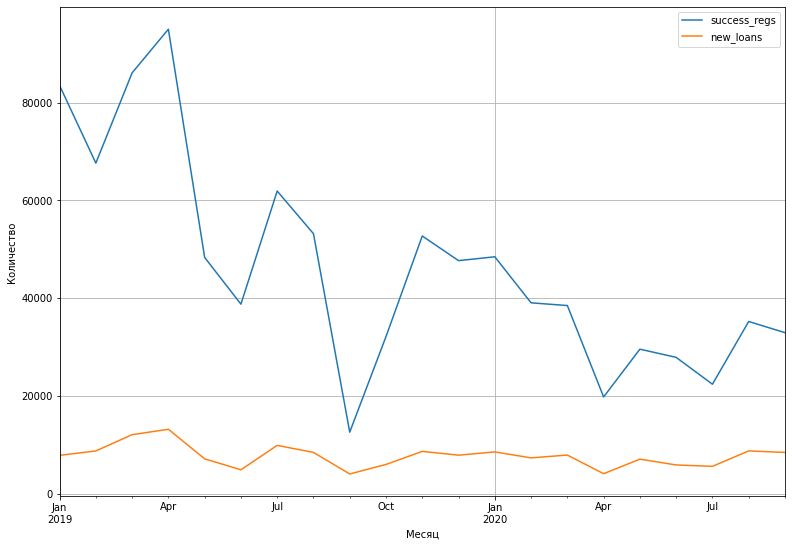

In [24]:
# теперь на одном графике сравним динамику успешных регистраций и новых займов
total_grouped_data[['success_regs', 'new_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

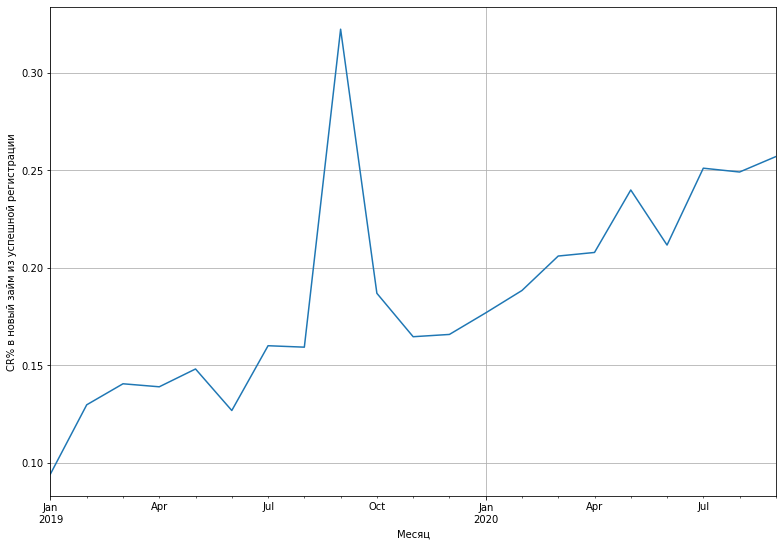

In [25]:
# а также посмотрим на конверсию в динамике
(total_grouped_data['new_loans'] / total_grouped_data['success_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% в новый займ из успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>при стабильном сокращении успешных регистраций кол-во новых займов осталось практически на том же уровне
        <li>можно констатировать, что произошло это в первую очередь за счет роста конверсии в новый заем с 0.15 до 0.25
        <li>однако это общие данные, которые состаят из различных источников трафика в тч высококонверсионной органики (в тч брендовой). Судя по данным из affise CPA канал в августе имел CR% = 17 
    </ul>
</div>